In [1]:
import sys
sys.path.append("../PSI-MI/")
from miHierarchy import *

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import math
from collections import Counter

## Function of gene ID conversion (2022-05-17)

In [2]:
geneName = pd.read_csv(r'../../data/Biomart_geneid/Biomart_geneid_mouse.txt',
                       sep="\t",
                       header=None)
geneName.columns = ['ID', 'Symbol']
id_count = dict(Counter(geneName['ID'].tolist()))
id_retain = [k for k,v in id_count.items() if v == 1]

geneName2 = geneName[geneName['ID'].isin(id_retain)]
id_name = dict(zip(geneName2['ID'], geneName2['Symbol']))

def id2name(id):
    if id in id_name.keys():
        return id_name[id]
    else:
        return 0

In [3]:
id2name("100009609")

'Vmn2r65'

# Mouse PPI data integration from different databases

## Raw data extraction
### BioGRID (2021-11-16)

In [3]:
gene_A = []
gene_B = []
method = []
pubmed = []
interaction_type = []
with open(r'../../data/PPIs/BIOGRID-ORGANISM-4.4.203.mitab/BIOGRID-ORGANISM-Mus_musculus-4.4.203.mitab.txt') as f:
    for row in f:
        if row.startswith("#ID"):
            pass
        else:
            col = row.split("\t")
            if col[9] == 'taxid:10090' and col[10] == 'taxid:10090':
                gene_A.append(id2name(col[0].replace('entrez gene/locuslink:', '')))
                gene_B.append(id2name(col[1].replace('entrez gene/locuslink:', '')))
                method.append(col[6].replace('psi-mi:"', '').replace('"', ''))
                pubmed.append(col[8])
                interaction_type.append(col[11].replace('psi-mi:"', '').replace('"', ''))
                
biogrid = pd.DataFrame({'gene_A': gene_A, 'gene_B': gene_B,
                         'interaction_detection_method': method,
                         'pubmed_id': pubmed,
                         'interaction_type': interaction_type,
                         'database': ['BioGRID'] * len(gene_A)})

In [4]:
biogrid.head()

,gene_A,gene_B,interaction_detection_method,pubmed_id,interaction_type,database
0,Ptpra,Ppp2r1a,MI:0004(affinity chromatography technology),pubmed:12952889,MI:0915(physical association),BioGRID
1,Ppp2r1a,Ptpra,MI:0004(affinity chromatography technology),pubmed:12952889,MI:0915(physical association),BioGRID
2,Pcna,Rev1,MI:0004(affinity chromatography technology),pubmed:16857592,MI:0915(physical association),BioGRID
3,Pcna,Rev1,MI:0401(biochemical),pubmed:16857592,MI:0914(association),BioGRID
4,Trappc5,Trappc3,MI:0401(biochemical),pubmed:17027922,MI:0914(association),BioGRID


In [5]:
biogrid.shape

(62751, 6)

### IntAct

In [6]:
gene_A = []
gene_B = []
method = []
pubmed = []
interaction_type = []
with open(r'../../data/PPIs/IntAct/intact.txt') as f:
    for row in f:
        if row.startswith("#ID"):
            pass
        else:
            col = row.strip().split('\t')
            if col[9] == 'taxid:10090(mouse)|taxid:10090(Mus musculus)' and col[10] == 'taxid:10090(mouse)|taxid:10090(Mus musculus)':
                gene_A.append(id2name(re.split('[:-]', col[0])[1]))
                gene_B.append(id2name(re.split('[:-]', col[1])[1]))
                method.append(col[6].replace('psi-mi:"', '').replace('"', ''))
                pubmed.append(re.search(r'(.*)(pubmed:[0-9]+)(\D*)(.*)', col[8]).group(2))
                interaction_type.append(col[11].replace('psi-mi:"', '').replace('"', ''))
                
intact = pd.DataFrame({'gene_A': gene_A, 'gene_B': gene_B,
                         'interaction_detection_method': method,
                         'pubmed_id': pubmed,
                         'interaction_type': interaction_type,
                         'database': ['IntAct'] * len(gene_A)})

In [7]:
#intact.head()
intact[intact.interaction_detection_method == "MI:0071(molecular sieving)"].head()

,gene_A,gene_B,interaction_detection_method,pubmed_id,interaction_type,database
260,Aire,Aire,MI:0071(molecular sieving),pubmed:11533054,MI:0915(physical association),IntAct
261,Aire,Aire,MI:0071(molecular sieving),pubmed:11533054,MI:0915(physical association),IntAct
667,Arid1a,0,MI:0071(molecular sieving),pubmed:11988099,MI:0915(physical association),IntAct
668,Arid1a,Smarcd1,MI:0071(molecular sieving),pubmed:11988099,MI:0915(physical association),IntAct
975,Hspa2,Hspa2,MI:0071(molecular sieving),pubmed:15498567,MI:0407(direct interaction),IntAct


In [8]:
intact.shape

(30391, 6)

### MINT

In [9]:
gene_A = []
gene_B = []
method = []
pubmed = []
interaction_type = []
with open(r'../../data/PPIs/MINT/MINT_mouse') as f:
    for row in f:
        col = row.strip().split('\t')
        if col[9] == 'taxid:10090(mouse)|taxid:10090(Mus musculus)' and col[10] == 'taxid:10090(mouse)|taxid:10090(Mus musculus)':
            gene_A.append(id2name(re.split('[:-]', col[0])[1]))
            gene_B.append(id2name(re.split('[:-]', col[1])[1]))
            method.append(col[6].replace('psi-mi:"', '').replace('"', ''))
            pubmed.append(re.search(r'(.*)(pubmed:[0-9]+)(\D*)(.*)', col[8]).group(2))
            interaction_type.append(col[11].replace('psi-mi:"', '').replace('"', ''))
            
mint = pd.DataFrame({'gene_A': gene_A, 'gene_B': gene_B,
                         'interaction_detection_method': method,
                         'pubmed_id': pubmed,
                         'interaction_type': interaction_type,
                         'database': ['MINT'] * len(gene_A)})

In [10]:
mint.head()

,gene_A,gene_B,interaction_detection_method,pubmed_id,interaction_type,database
0,Ncoa2,Yes1,MI:0006(anti bait coimmunoprecipitation),pubmed:14980517,MI:0914(association),MINT
1,Ncoa2,Fyn,MI:0006(anti bait coimmunoprecipitation),pubmed:14980517,MI:0914(association),MINT
2,Ptpn9,Nsf,MI:0096(pull down),pubmed:15322554,MI:0915(physical association),MINT
3,Ptpn9,Nsf,MI:0096(pull down),pubmed:15322554,MI:0915(physical association),MINT
4,Prnp,Psmd6,MI:0096(pull down),pubmed:21743439,MI:0915(physical association),MINT


In [11]:
mint.shape

(7010, 6)

### DIP

In [12]:
gene_A = []
gene_B = []
method = []
pubmed = []
interaction_type = []
with open(r'../../data/PPIs/DIP/Mmusc20170205.txt') as f:
    for row in f:
        if row.startswith("ID"):
            pass
        else:
            col = row.strip().split("\t")
            if col[9] == 'taxid:10090(Mus musculus)' and col[10] == 'taxid:10090(Mus musculus)':
                a = re.split('\\|', col[0])[-1]
                b = re.split('\\|', col[1])[-1]
                #print(a + "\t" + b)
                if bool(re.search("DIP", a)) or bool(re.search("DIP", b)):
                    pass
                else:
                    gene_A.append(id2name(re.split(':', a)[1]))
                    gene_B.append(id2name(re.split(':', b)[1]))
                    method.append(col[6])
                    pubmed.append(re.sub(r'\|pubmed:DIP-[0-9]+', '', col[8]))
                    interaction_type.append(col[11])
                        
dip = pd.DataFrame({'gene_A': gene_A, 'gene_B': gene_B,
                         'interaction_detection_method': method,
                         'pubmed_id': pubmed,
                         'interaction_type': interaction_type,
                         'database': ['DIP'] * len(gene_A)})

In [13]:
dip.head()

,gene_A,gene_B,interaction_detection_method,pubmed_id,interaction_type,database
0,Bcl2,Prnp,MI:0018(two hybrid),pubmed:8738158S,MI:0218(physical interaction),DIP
1,Cish,Epor,MI:0019(coimmunoprecipitation),pubmed:7796808S,MI:0218(physical interaction),DIP
2,Sla,Epha2,MI:0018(two hybrid)|MI:0019(coimmunoprecipitat...,pubmed:7543898S|pubmed:7543898S,MI:0218(physical interaction)|MI:0218(physical...,DIP
3,0,Epha2,MI:0018(two hybrid)|MI:0019(coimmunoprecipitat...,pubmed:7982920S|pubmed:7982920S,MI:0218(physical interaction)|MI:0218(physical...,DIP
4,Traf2,Traf2,MI:0019(coimmunoprecipitation),pubmed:8702708S,MI:0218(physical interaction),DIP


In [14]:
dip.shape

(1457, 6)

In [15]:
dip2 = dip[['gene_A', 'interaction_detection_method']]
dip2 = dip2.drop('interaction_detection_method', axis=1).\
    join(dip2['interaction_detection_method'].str.split('|', expand = True).\
         stack().reset_index(level=1, drop=True).rename('interaction_detection_method'))

dip3 = dip[['gene_B', 'pubmed_id']]
dip3 = dip3.drop('pubmed_id', axis=1).\
    join(dip3['pubmed_id'].str.split('|', expand = True).\
         stack().reset_index(level=1, drop=True).rename('pubmed_id'))

dip4 = dip[['interaction_type', 'database']]
dip4 = dip4.drop('interaction_type', axis=1).\
    join(dip4['interaction_type'].str.split('|', expand = True).\
         stack().reset_index(level=1, drop=True).rename('interaction_type'))

dip5 = pd.concat([dip2, dip3, dip4], axis=1)
dip5 = dip5[['gene_A', 'gene_B', 'interaction_detection_method', 'pubmed_id',
             'interaction_type', 'database']]
dip5.head()

,gene_A,gene_B,interaction_detection_method,pubmed_id,interaction_type,database
0,Bcl2,Prnp,MI:0018(two hybrid),pubmed:8738158S,MI:0218(physical interaction),DIP
1,Cish,Epor,MI:0019(coimmunoprecipitation),pubmed:7796808S,MI:0218(physical interaction),DIP
2,Sla,Epha2,MI:0018(two hybrid),pubmed:7543898S,MI:0218(physical interaction),DIP
2,Sla,Epha2,MI:0019(coimmunoprecipitation),pubmed:7543898S,MI:0218(physical interaction),DIP
3,0,Epha2,MI:0018(two hybrid),pubmed:7982920S,MI:0218(physical interaction),DIP


In [16]:
dip5.shape

(2685, 6)

### Skinnider et al. 2021 (2021-11-16)

In [17]:
sec = pd.ExcelFile('../../data/PPIs/Skinnider_2021.xlsx')
sec = pd.read_excel(sec, 'Table S3')

In [18]:
sec.head()

,Protein A,Protein B,Tissue,Precision
0,Psmb1,Psma7,Brain,1.0
1,Cct8,Cct5,Brain,1.0
2,Psmb1,Psma3,Brain,1.0
3,Psma6,Psma3,Brain,1.0
4,Psmb7,Psma1,Brain,1.0


In [19]:
sec.shape

(192460, 4)

In [20]:
sec2 = sec[['Protein B', 'Protein A', 'Tissue']]
sec2.columns = sec.columns[0:3]
sec2 = pd.concat([sec[['Protein A', 'Protein B', 'Tissue']], sec2], axis = 0, ignore_index = True)
sec2 = sec2.drop_duplicates()
sec2.head()

,Protein A,Protein B,Tissue
0,Psmb1,Psma7,Brain
1,Cct8,Cct5,Brain
2,Psmb1,Psma3,Brain
3,Psma6,Psma3,Brain
4,Psmb7,Psma1,Brain


In [21]:
sec2.shape

(384920, 3)

In [22]:
def comb(df):
    return ';'.join(df.values)

sec3 = sec2.groupby(['Protein A', 'Protein B'])['Tissue'].apply(comb)
interaction_list = []
for i in range(len(sec3.index)):
    interaction_list.append(sec3.index[i])
sec4 = pd.DataFrame(interaction_list)
sec4.columns = sec3.index.names
sec4['Tissue'] = sec3.values

In [23]:
sec4.head()

,Protein A,Protein B,Tissue
0,0610009B22Rik,Chdh,Kidney
1,0610009B22Rik,Eif4a3,Kidney
2,0610009B22Rik,Fmr1,Kidney
3,0610009B22Rik,Lman1,Kidney
4,0610009B22Rik,Rab18,Kidney


In [24]:
sec4.shape

(251392, 3)

In [25]:
# (2021-11-16)
sec5 = sec4[['Protein A', 'Protein B']]
sec5.columns = ['gene_A', 'gene_B']
sec5['interaction_detection_method'] = 'MI:0071(molecular sieving)'  # synonym: "Size Exclusion Chromatography (SEC)"
sec5['pubmed_id'] = 'pubmed:34214469'
sec5['interaction_type'] = 'MI:0915(physical association)'
sec5['database'] = 'Skinnider2021'
sec5.head()

,gene_A,gene_B,interaction_detection_method,pubmed_id,interaction_type,database
0,0610009B22Rik,Chdh,MI:0071(molecular sieving),pubmed:34214469,MI:0915(physical association),Skinnider2021
1,0610009B22Rik,Eif4a3,MI:0071(molecular sieving),pubmed:34214469,MI:0915(physical association),Skinnider2021
2,0610009B22Rik,Fmr1,MI:0071(molecular sieving),pubmed:34214469,MI:0915(physical association),Skinnider2021
3,0610009B22Rik,Lman1,MI:0071(molecular sieving),pubmed:34214469,MI:0915(physical association),Skinnider2021
4,0610009B22Rik,Rab18,MI:0071(molecular sieving),pubmed:34214469,MI:0915(physical association),Skinnider2021


## Intrgration

In [26]:
integrated_ppi = pd.concat([biogrid, intact, mint, dip5, sec5])
integrated_ppi2 = integrated_ppi[(integrated_ppi.gene_A != 0) & (integrated_ppi.gene_B != 0)]
integrated_ppi2 = integrated_ppi2.drop_duplicates()
integrated_ppi2 = integrated_ppi2[integrated_ppi2.gene_A != integrated_ppi2.gene_B]
integrated_ppi2 = integrated_ppi2.iloc[:,[0,1,2,3,5]]

In [27]:
integrated_ppi.shape

(354229, 6)

In [28]:
integrated_ppi2.shape

(335711, 5)

In [29]:
integrated_ppi2.head()

,gene_A,gene_B,interaction_detection_method,pubmed_id,database
0,Ptpra,Ppp2r1a,MI:0004(affinity chromatography technology),pubmed:12952889,BioGRID
1,Ppp2r1a,Ptpra,MI:0004(affinity chromatography technology),pubmed:12952889,BioGRID
2,Pcna,Rev1,MI:0004(affinity chromatography technology),pubmed:16857592,BioGRID
3,Pcna,Rev1,MI:0401(biochemical),pubmed:16857592,BioGRID
4,Trappc5,Trappc3,MI:0401(biochemical),pubmed:17027922,BioGRID


In [30]:
def mi_grandparent(idm):
    mi = re.search(r'(MI:[0-9]+)(\(.*\))', idm).group(1)
    return ",".join(find_grandparent(mi))

In [31]:
integrated_ppi2['grandparent_MI'] = integrated_ppi2['interaction_detection_method'].apply(mi_grandparent)
integrated_ppi2 = integrated_ppi2[integrated_ppi2.grandparent_MI != "-"]

In [32]:
integrated_ppi2.head()

,gene_A,gene_B,interaction_detection_method,pubmed_id,database,grandparent_MI
0,Ptpra,Ppp2r1a,MI:0004(affinity chromatography technology),pubmed:12952889,BioGRID,MI:0401
1,Ppp2r1a,Ptpra,MI:0004(affinity chromatography technology),pubmed:12952889,BioGRID,MI:0401
2,Pcna,Rev1,MI:0004(affinity chromatography technology),pubmed:16857592,BioGRID,MI:0401
3,Pcna,Rev1,MI:0401(biochemical),pubmed:16857592,BioGRID,MI:0401
4,Trappc5,Trappc3,MI:0401(biochemical),pubmed:17027922,BioGRID,MI:0401


In [64]:
Counter(integrated_ppi2['grandparent_MI'].tolist())

Counter({'MI:0401': 77362,
         'MI:0090': 4122,
         'MI:0428': 1083,
         'MI:0254': 823,
         'MI:0013': 520,
         'MI:0401,MI:0013': 251567,
         'MI:0013,MI:0090': 21})

In [63]:
integrated_ppi2.shape

(335498, 6)

In [65]:
mi_remove = ['MI:0254', 'MI:1088', 'MI:0255'] # genetic interference, phenotype-based detection assay, post transcriptional interference
integrated_ppi2 = integrated_ppi2[~integrated_ppi2.grandparent_MI.isin(mi_remove)]

In [66]:
integrated_ppi2.shape

(334675, 6)

### 1. Divide the PPIs into high-through (HT) and low-through (LT) (2022-05-26)

In [67]:
integrated_ppi3 = integrated_ppi2[['gene_B', 'gene_A', 'interaction_detection_method', 
                                   'pubmed_id', 'database']]
integrated_ppi3.columns = integrated_ppi2.columns[0:5]
integrated_ppi3 = pd.concat([integrated_ppi2.iloc[:,0:5], integrated_ppi3], 
                            axis = 0, ignore_index = True)
integrated_ppi3 = integrated_ppi3.drop_duplicates()

In [68]:
integrated_ppi3.head()

,gene_A,gene_B,interaction_detection_method,pubmed_id,database
0,Ptpra,Ppp2r1a,MI:0004(affinity chromatography technology),pubmed:12952889,BioGRID
1,Ppp2r1a,Ptpra,MI:0004(affinity chromatography technology),pubmed:12952889,BioGRID
2,Pcna,Rev1,MI:0004(affinity chromatography technology),pubmed:16857592,BioGRID
3,Pcna,Rev1,MI:0401(biochemical),pubmed:16857592,BioGRID
4,Trappc5,Trappc3,MI:0401(biochemical),pubmed:17027922,BioGRID


In [69]:
integrated_ppi3.shape

(412684, 5)

In [70]:
throughput = integrated_ppi3[['gene_A', 'gene_B', 'pubmed_id']]
throughput = throughput.drop_duplicates()

pubmeds = throughput['pubmed_id'].tolist()
pubmed_num = Counter(pubmeds)

def ht_lt(pubmed):
    if pubmed_num[pubmed] >= 200:
        return "HT"
    else:
        return "LT"

In [71]:
throughput.shape

(390602, 3)

In [72]:
integrated_ppi3['throughput'] = integrated_ppi3['pubmed_id'].apply(ht_lt)

In [73]:
integrated_ppi3.head()

,gene_A,gene_B,interaction_detection_method,pubmed_id,database,throughput
0,Ptpra,Ppp2r1a,MI:0004(affinity chromatography technology),pubmed:12952889,BioGRID,LT
1,Ppp2r1a,Ptpra,MI:0004(affinity chromatography technology),pubmed:12952889,BioGRID,LT
2,Pcna,Rev1,MI:0004(affinity chromatography technology),pubmed:16857592,BioGRID,LT
3,Pcna,Rev1,MI:0401(biochemical),pubmed:16857592,BioGRID,LT
4,Trappc5,Trappc3,MI:0401(biochemical),pubmed:17027922,BioGRID,LT


### 2. Combine the same interaction from different literatures, experimental scales, databases and method (PSI-MI)

In [74]:
def inter_comb(name):
    ppi = integrated_ppi3[['gene_A','gene_B',name]]
    ppi = ppi.drop_duplicates()
    ppi2 = ppi.groupby(['gene_A','gene_B'])[name].apply(comb)
    interaction_list = []
    for i in range(len(ppi2.index)):
        interaction_list.append(ppi2.index[i])
    ppi3 = pd.DataFrame(interaction_list)
    ppi3.columns = ppi2.index.names
    ppi3[name] = ppi2.values
    return ppi3

In [75]:
integrated_ppi4 = pd.DataFrame({'gene_A':[], 'gene_B':[]})
for name in integrated_ppi3.columns[2:6].to_list():
    ppi = inter_comb(name)
    integrated_ppi4 = pd.merge(integrated_ppi4, ppi, how='right',
                               on=['gene_A', 'gene_B'])

In [76]:
integrated_ppi4.head()

,gene_A,gene_B,interaction_detection_method,pubmed_id,database,throughput
0,0610009B22Rik,Chdh,MI:0071(molecular sieving),pubmed:34214469,Skinnider2021,HT
1,0610009B22Rik,Eif4a3,MI:0071(molecular sieving),pubmed:34214469,Skinnider2021,HT
2,0610009B22Rik,Fmr1,MI:0071(molecular sieving),pubmed:34214469,Skinnider2021,HT
3,0610009B22Rik,Lman1,MI:0071(molecular sieving),pubmed:34214469,Skinnider2021,HT
4,0610009B22Rik,Rab18,MI:0071(molecular sieving),pubmed:34214469,Skinnider2021,HT


In [77]:
Counter(integrated_ppi4['throughput'].tolist())

Counter({'HT': 342754, 'LT': 27470, 'LT;HT': 1429, 'HT;LT': 1155})

### 3. Remove the replicated interaction pairs (retain A-B, but not B-A)

In [78]:
interaction = []
gene_A = []
gene_B = []
interaction_detection_method = []
pubmed_id = []
database = []
throughput = []

for i in range(integrated_ppi4.shape[0]):
    if integrated_ppi4.iloc[i,1] + '-' + integrated_ppi4.iloc[i,0] in interaction:
        pass
    else:
        interaction.append(integrated_ppi4.iloc[i,0] + '-' + integrated_ppi4.iloc[i,1])
        gene_A.append(integrated_ppi4.iloc[i,0])
        gene_B.append(integrated_ppi4.iloc[i,1])
        interaction_detection_method.append(integrated_ppi4.iloc[i,2])
        pubmed_id.append(integrated_ppi4.iloc[i,3])
        database.append(integrated_ppi4.iloc[i,4])
        throughput.append(';'.join(sorted(integrated_ppi4.iloc[i,5].split(';'))))
        
integrated_ppi5 = pd.DataFrame({'Gene_A': gene_A, 
                                'Gene_B': gene_B, 
                                'Interaction_detection_method': interaction_detection_method, 
                                'Pubmed_id': pubmed_id,
                                'Database': database,
                                'Throughput': throughput})

In [79]:
integrated_ppi5.head()

,Gene_A,Gene_B,Interaction_detection_method,Pubmed_id,Database,Throughput
0,0610009B22Rik,Chdh,MI:0071(molecular sieving),pubmed:34214469,Skinnider2021,HT
1,0610009B22Rik,Eif4a3,MI:0071(molecular sieving),pubmed:34214469,Skinnider2021,HT
2,0610009B22Rik,Fmr1,MI:0071(molecular sieving),pubmed:34214469,Skinnider2021,HT
3,0610009B22Rik,Lman1,MI:0071(molecular sieving),pubmed:34214469,Skinnider2021,HT
4,0610009B22Rik,Rab18,MI:0071(molecular sieving),pubmed:34214469,Skinnider2021,HT


In [80]:
integrated_ppi5.shape

(186404, 6)

In [59]:
integrated_ppi5.to_csv(path_or_buf='../../result/integrated_ppi/PPI_Mm/integrated_ppi.txt',
                       index = False, sep = '\t')

In [ ]:
integrated_ppi6 = integrated_ppi5.iloc[:, :2]
integrated_ppi6.to_csv(path_or_buf='../../result/integrated_ppi_Mm.txt', 
                       header=False, index=False)

### 4. Basic statistics (2022-05-26)

In [60]:
"""The number of PPIs supported by different scale experiments"""
scale_num = pd.DataFrame.from_dict(Counter(integrated_ppi5['Throughput'].tolist()), 
                                   orient="index", columns = ['Number'])
scale_num = scale_num.reset_index().rename(columns = {'index': 'Throughput'})

In [61]:
scale_num

,Throughput,Number
0,HT,171848
1,LT,13976
2,HT;LT,1297


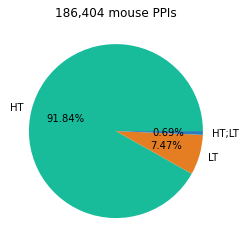

In [82]:
#from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.pie(scale_num['Number'].tolist(), 
        labels=scale_num['Throughput'], 
        autopct='%1.2f%%', 
        colors=['#18BC9B', '#E57E23', '#2780B9'])
plt.title('186,404 mouse PPIs')
#plt.axis('equal')
#plt.show()
plt.savefig('../../result/integrated_ppi/PPI_Mm/throughput_number.pdf')

# Network analysis

In [2]:
import networkx as nx

### 1. Network topological properties (2022-05-30)

In [26]:
ppi = pd.read_csv(r'../../result/integrated_ppi/PPI_Mm/integrated_ppi.txt', sep="\t")

In [27]:
ppi.head()

,Gene_A,Gene_B,Interaction_detection_method,Pubmed_id,Database,Throughput
0,0610009B22Rik,Chdh,MI:0071(molecular sieving),pubmed:34214469,Skinnider2021,HT
1,0610009B22Rik,Eif4a3,MI:0071(molecular sieving),pubmed:34214469,Skinnider2021,HT
2,0610009B22Rik,Fmr1,MI:0071(molecular sieving),pubmed:34214469,Skinnider2021,HT
3,0610009B22Rik,Lman1,MI:0071(molecular sieving),pubmed:34214469,Skinnider2021,HT
4,0610009B22Rik,Rab18,MI:0071(molecular sieving),pubmed:34214469,Skinnider2021,HT


In [28]:
G = nx.from_pandas_edgelist(ppi[['Gene_A', 'Gene_B']], source='Gene_A', target='Gene_B', 
                            edge_attr=None, create_using=None)

In [33]:
"""Global network"""
print("Number of nodes N\t", len(list(G.nodes)))
print("Number of edges N\t", len(list(G.edges)))

Number of nodes N	 11362
Number of edges N	 187121


In [34]:
"""The largest connected component"""
largest_components=max(nx.connected_components(G),key=len) # genes in the largest connected component
S = [G.subgraph(c).copy() for c in nx.connected_components(G)] # all the components
max_S = nx.to_pandas_edgelist(S[0]) # the largest connected component
max_S.to_csv(path_or_buf='../../result/integrated_ppi/PPI_Mm/integrated_ppi_largest_component.txt', index = 0, sep = '\t', header=0)

In [35]:
"""Global network"""
print("Number of nodes N\t", len(list(S[0].nodes)))
print("Number of edges N\t", len(list(S[0].edges)))
print("Mean degree <k>\t", len(list(S[0].edges))*2/len(list(S[0].nodes)))
print("Mean clustering <c>\t", nx.average_clustering(S[0]))
print("Mean distance <d>\t", nx.average_shortest_path_length(S[0]))
print("Diameter dmax\t", nx.diameter(S[0]))

Number of nodes N	 11297
Number of edges N	 187081
Mean degree <k>	 33.12047446224661
Mean clustering <c>	 0.21965958227985397
Mean distance <d>	 3.430253221605375
Diameter dmax	 12


In [6]:
"""For each node"""
nodes = sorted(list(G.nodes()))

Degree = nx.degree(G)  # Degree
k = [Degree[node] for node in nodes]

Betweenness_centrality = nx.betweenness_centrality(G)  # Betweenness
BC = [Betweenness_centrality[node] for node in nodes]

Eigenvector_centrality = nx.eigenvector_centrality(G)  # Eigenvector centrality
x = [Eigenvector_centrality[node] for node in nodes]

Clustering_coefficient = nx.clustering(G) # local clustering coefficient
C = [Clustering_coefficient[node] for node in nodes]

Assortativity = nx.average_neighbor_degree(G) # The average neighborhood degree of a node
NC = [Assortativity[node] for node in nodes]

Closeness_centrality = nx.closeness_centrality(G) # reciprocal of the average shortest path distance
SP = [Closeness_centrality[node] for node in nodes]

node_info = pd.DataFrame({'Gene': nodes,
                          'Degree': k, 
                          'Betweenness_centrality': BC,
                          'Eigenvector_centrality': x,
                          'Clustering_coefficient': C,
                          'Assortativity': NC,
                          'Closeness_centrality': SP})

In [7]:
node_info.head()

,Gene,Degree,Betweenness_centrality,Eigenvector_centrality,Clustering_coefficient,Assortativity,Closeness_centrality
0,0610009B22Rik,8,4.599973e-07,0.000113,0.571429,97.000000,0.298373
1,0610010K14Rik,71,3.448709e-05,0.003963,0.505433,208.338028,0.340572
2,1110004F10Rik,8,1.330960e-04,0.000337,0.142857,126.750000,0.301643
3,1110008P14Rik,2,4.727426e-08,0.000017,0.000000,67.500000,0.270531
4,1700001K19Rik,1,0.000000e+00,0.000022,0.000000,128.000000,0.263852


In [8]:
node_info.shape

(11362, 7)

In [31]:
(187121*2)/11362

32.93803907762718

In [23]:
np.mean(node_info['Degree'].tolist())

32.93803907762718

In [14]:
node_info.to_csv(path_or_buf = '../../result/integrated_ppi/PPI_Mm/node_centrality.txt', index=False, sep='\t')

### 2. Degree distribution

In [9]:
degree_freq = Counter(node_info['Degree'].tolist())

In [15]:
log10d = []
log10f = []
for i in degree_freq:
    log10d.append(math.log10(i))
    log10f.append(math.log10(degree_freq[i]/node_info.shape[0]))

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
regressor = LinearRegression()
regressor = regressor.fit(np.reshape(log10d, (-1, 1)), np.reshape(log10f, (-1, 1)))
print(regressor.coef_, regressor.intercept_)

[[-1.30252697]] [-0.47276223]


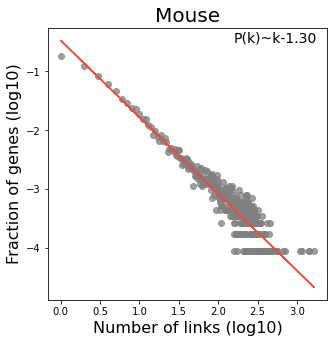

In [20]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.figure(figsize=(5, 5))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.title("Mouse", fontsize=20)
plt.xlabel("Number of links (log10)", fontsize=16)
plt.ylabel("Fraction of genes (log10)", fontsize=16)

plt.scatter(log10d, log10f, c="grey", alpha=0.75)
plt.plot(np.reshape(log10d, (-1, 1)), 
         regressor.predict(np.reshape(log10d, (-1, 1))), 
         c="#E74C3C")

plt.text(2.2, -0.5, 'P(k)~k-1.30', size = 14)
#plt.show()

plt.savefig('../../result/integrated_ppi/PPI_Mm/degree_distribution.pdf')